In [1]:
AGENT_NAME = 'default_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_500'
ADVERSARY_PATH = 'Models\Adversary\default_adversary_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_default_rwd_480'
DATASET_NAME = 'citylearn_challenge_2022_phase_2' #only action is electrical storage
ATTACK = 'BB'

In [2]:
from stable_baselines3 import PPO

from citylearn.data import DataSet

from art.attacks.evasion.brendel_bethge import BrendelBethgeAttack as BBA

import pandas as pd
import numpy as np
import os

import KBMproject.utilities as utils

%matplotlib inline

In [3]:
schema = DataSet.get_schema(DATASET_NAME)

Define RL agent

In [4]:
agent = PPO.load(path=f"{AGENT_NAME}")
print('Model loaded from storage')

Model loaded from storage


In [5]:
adv_path = os.path.join(os.getcwd(), '..',ADVERSARY_PATH) #get adversary from parent directory
adv_path = os.path.normpath(adv_path) #resolve '..'
adversary = PPO.load(path=adv_path)
print('Model loaded from storage')

Model loaded from storage


In [6]:
bins = agent.action_space[0].n
env = utils.make_discrete_env(schema=schema,  
                        action_bins=bins,
                        seed=42)

In [7]:
observation_masks = pd.Series(1, index=env.observation_names[0]).to_frame(name='all')
observation_masks['mask_time'] = observation_masks['all']
observation_masks['mask_time'][observation_masks.index.str.contains('month|day|hour')] = 0

In [8]:
df_baseline = pd.concat([pd.read_csv('baseline_obs.csv', index_col=0,dtype='float32'),
                        pd.read_csv('baseline_obs_a_confidence.csv', index_col=0)], axis='columns')

Below, for each action we select the sample with the highest logit softmax/confidence

In [9]:
df_max_confidence_samples = df_baseline.loc[df_baseline.groupby('action')['confidence'].idxmax()]
df_max_confidence_samples = df_max_confidence_samples.drop(columns='confidence')
df_max_confidence_samples = df_max_confidence_samples.set_index('action')

In [10]:
df_max_confidence_samples

,month_cos,month_sin,day_type_cos,day_type_sin,hour_cos,hour_sin,outdoor_dry_bulb_temperature,outdoor_dry_bulb_temperature_predicted_6h,outdoor_dry_bulb_temperature_predicted_12h,outdoor_dry_bulb_temperature_predicted_24h,...,direct_solar_irradiance_predicted_24h,carbon_intensity,non_shiftable_load,solar_generation,electrical_storage_soc,net_electricity_consumption,electricity_pricing,electricity_pricing_predicted_6h,electricity_pricing_predicted_12h,electricity_pricing_predicted_24h
action,,,,,,,,,,,,,,,,,,,,,
0,0.750000,0.933013,0.853553,0.146447,0.250000,0.933013,0.270677,0.375940,0.270677,0.248120,...,0.000000,0.116446,2.167520e-01,0.000630,3.736236e-10,0.989130,0.000000,0.000000,0.878788,0.000000
1,0.066987,0.250000,0.853553,0.146447,0.853553,0.853553,0.500000,0.687970,0.706767,0.477444,...,0.000000,0.426018,6.952469e-02,0.000000,8.973659e-08,0.988633,0.030303,0.030303,0.030303,0.030303
2,0.000000,0.500000,0.853553,0.853553,0.853553,0.853553,0.394737,0.477444,0.541353,0.394737,...,0.000000,0.426147,5.283258e-02,0.000000,7.764039e-07,0.988507,0.030303,0.030303,0.030303,0.030303
3,0.750000,0.066987,0.000000,0.500000,1.000000,0.500000,0.417293,0.458647,0.518797,0.375940,...,0.000000,0.118741,1.474507e-01,0.000000,1.478574e-03,0.989125,0.000000,0.000000,0.000000,0.000000
4,0.933013,0.750000,0.853553,0.146447,0.853553,0.146447,0.312030,0.206767,0.229323,0.270677,...,0.000000,0.368078,3.878112e-01,0.000000,1.507442e-10,0.991046,0.000000,0.000000,0.000000,0.000000
5,0.250000,0.933013,0.500000,0.000000,0.629410,0.982963,0.289474,0.563910,0.477444,0.394737,...,0.000000,0.170730,9.694734e-03,0.000000,3.721264e-10,0.988180,0.000000,0.000000,0.878788,0.000000
6,0.750000,0.066987,0.500000,0.000000,0.933013,0.750000,0.406015,0.436090,0.646617,0.477444,...,0.000000,0.125903,2.251631e-01,0.000000,5.764221e-07,0.989813,0.000000,0.000000,0.000000,0.000000
7,1.000000,0.500000,0.146447,0.146447,0.250000,0.066987,0.500000,0.353383,0.248120,0.458647,...,0.352571,0.352801,5.513207e-01,0.000021,8.144526e-01,0.991078,0.878788,0.000000,0.000000,0.878788
8,0.000000,0.500000,0.146447,0.146447,0.750000,0.066987,0.500000,0.458647,0.541353,0.477444,...,0.000000,0.572011,1.513359e-01,0.000000,3.649878e-01,0.988372,1.000000,0.030303,0.030303,0.575758


In [11]:
from art.estimators.classification import PyTorchClassifier as classifier
from torch.nn import CrossEntropyLoss
victim_policy = classifier(
    model=utils.extract_actor(agent),
    loss=CrossEntropyLoss(), 
    nb_classes=env.action_space[0].n,
    input_shape=agent.observation_space.shape,
    device_type='gpu',
    clip_values = (agent.observation_space.low.min(),agent.observation_space.high.max()) #min and max values of each feature, brendle bethge attack only supports floats values and not array
    )

In [12]:
np.argmax(victim_policy.predict(df_max_confidence_samples.to_numpy(dtype='float32')), axis=1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 19], dtype=int64)

In [13]:
dict_samples = df_max_confidence_samples.T.to_dict()

In [14]:
np.expand_dims(np.array(list(df_max_confidence_samples.T.to_dict()[0.0].values())), axis=0)

array([[7.50000000e-01, 9.33012724e-01, 8.53553414e-01, 1.46446615e-01,
        2.50000000e-01, 9.33012724e-01, 2.70676702e-01, 3.75939846e-01,
        2.70676702e-01, 2.48120308e-01, 8.11111093e-01, 7.55555570e-01,
        9.22222197e-01, 9.55555558e-01, 5.21140620e-02, 2.88102269e-01,
        0.00000000e+00, 8.25958699e-02, 1.04931789e-03, 8.39454308e-03,
        0.00000000e+00, 0.00000000e+00, 1.16445877e-01, 2.16751993e-01,
        6.29768299e-04, 3.73623632e-10, 9.89130259e-01, 0.00000000e+00,
        0.00000000e+00, 8.78787875e-01, 0.00000000e+00]])

In [17]:
%%time
#%%capture
import logging
logging.basicConfig(level=logging.INFO)
kwargs = dict(norm= np.inf,
        targeted=True, #default false
        overshoot= 1.1,
        steps=1000,
        lr=1e-3,
        lr_decay=0.5,
        lr_num_decay=20,
        momentum=0.8,
        binary_search_steps=10,
        init_size=1_000_000, #default 100, finds sample matching the target class through iterative random search
        batch_size=1,)
attack = utils.define_attack(agent, env, BBA, **kwargs )
kpi, obs, adv_obs, asr = utils.eval_targeted_attack(agent, adversary, env, attack,
                                                    mask=observation_masks['mask_time'].to_numpy(),
                                                    time_steps=None,
                                                    #start_points = dict_samples #random search is more effective for finding starting points?!
                                                    )
print(f'The ASR is {asr}')

INFO:art.estimators.classification.pytorch:Inferred 5 hidden layers on PyTorch classifier.
INFO:art.estimators.classification.pytorch:Inferred 5 hidden layers on PyTorch classifier.
100%|█████████▉| 8758/8759 [26:51:26<00:11, 11.04s/it]


The ASR is 1.0
CPU times: total: 1d 2h 50min 44s
Wall time: 1d 2h 51min 27s


Sometimes this works for the first sample, but not always, usually raises the assert error. I think env.reset() always returns the same initial state, so is the issue the estimator returning different actions for the same sample? could better samples be chosen? can we measure the confidence? Do the SB3 predictions match the ART estimator predicitons? YES

After adding an error message to the assert, it seems that the model consistently predicts 1 instead of 19 for this sample. when it predicted 19 after many attempts, the next time it printed: estimator predicted: [8] based on the starting point for target: [0]

removing the assert statment leads to an ASR of 0, even with starting points.

How could the estimator differ between the attack and generating actions?

Why is bb infering 5 hidden layer when there are only 2? INFO:art.estimators.classification.pytorch:Inferred 5 hidden layers on PyTorch classifier

While providing startin points was not effective for the reasons above, finding an starting point through a random search with 1000x the default budget was effective for the first 10 samples

In [18]:
display(kpi)

cost_function
annual_peak_average                       1.727378
carbon_emissions_total                    3.230139
cost_total                                3.036743
daily_one_minus_load_factor_average       0.960458
daily_peak_average                        2.930483
electricity_consumption_total             3.272208
monthly_one_minus_load_factor_average     1.002596
ramping_average                          17.457390
zero_net_energy                           1.731706
Name: District, dtype: float64

In [19]:
df_targeted_obs = pd.DataFrame(obs)
df_targeted_obs.to_csv(f'optimal {ATTACK} observations.csv')
df_targeted_obs = pd.DataFrame(adv_obs)
df_targeted_obs.to_csv(f'optimal {ATTACK} adversarial observations.csv')

In [20]:
df_kpis = pd.read_csv('KPIs.csv', index_col='cost_function')
df_kpis

,baseline,random_noise,untargeted_adversarial_examples,untargeted_adv_v_threshold,Adv_v25_untargered_kpis,Adv_v75_untargered_kpis,df_v_ablation_kpis,optimal_adv
cost_function,,,,,,,,
annual_peak_average,1.102271,1.009338,1.198347,1.102271,1.102270,1.102271,1.068404,1.102260
carbon_emissions_total,0.869186,0.870929,0.902045,0.891469,0.900611,0.880414,0.889796,0.876466
cost_total,0.787803,0.786467,0.816997,0.805982,0.814078,0.799415,0.806549,0.795443
daily_one_minus_load_factor_average,1.095762,1.091588,0.397182,1.002500,0.997434,0.365708,1.050107,1.045433
daily_peak_average,0.894595,0.896781,0.961207,0.930231,0.945812,0.913327,0.939143,0.912418
electricity_consumption_total,0.879108,0.881392,0.910717,0.901177,0.909467,0.890338,0.898543,0.885576
monthly_one_minus_load_factor_average,0.988364,0.981307,0.992850,0.987415,0.991820,0.986949,0.993147,0.990366
ramping_average,1.093749,1.105215,1.271853,1.196971,1.230539,1.151861,1.216366,1.122770
zero_net_energy,1.107710,1.107912,1.108499,1.109079,1.108982,1.108470,1.108584,1.108495


In [23]:
df_kpis[f'optimal_{ATTACK}'] = kpi.values

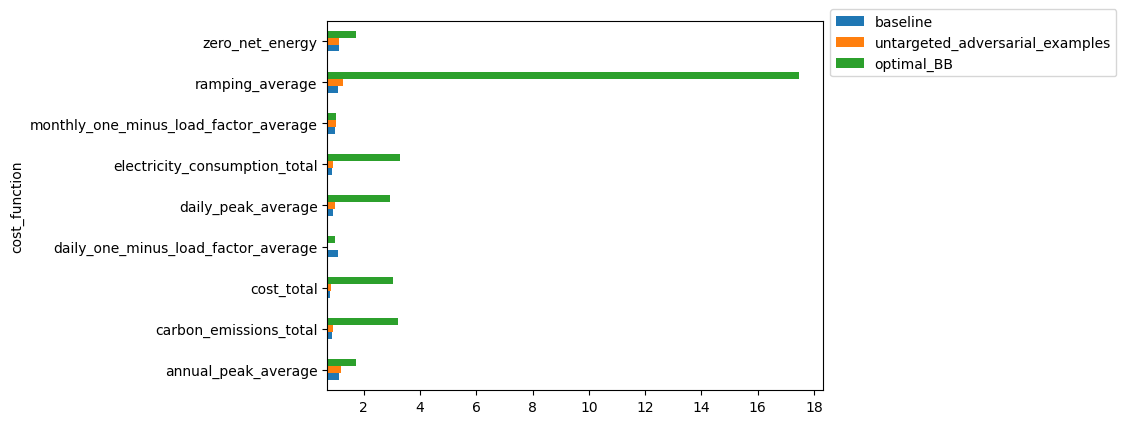

In [24]:
df_kpis[['baseline','untargeted_adversarial_examples',f'optimal_{ATTACK}']].plot.barh(xlim=0.7).legend(bbox_to_anchor=(1.0, 1.05))

In [25]:
df_kpis.to_csv('KPIs.csv')